## Activating GPU for Tensorflow

Allow Tensorflow to use GPU to speed up model training

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

## Importing Libraries

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import VGG19
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.callbacks import ModelCheckpoint

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

## Data Loading

Load data from their directories and then labeling the data with their flower types

In [ ]:
IMG_SIZE=224
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
name_json = data_dir + '/cat_to_name.json'

X_train = []
y_train = []
for folder in os.listdir(train_dir):
    folderpath = train_dir + '/' + folder
    for filename in os.listdir(folderpath):
        filepath = folderpath + '/' + filename
        img = cv2.imread(filepath)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        X_train.append(np.array(img))
        y_train.append(folder)

X_test = []
for filename in os.listdir(test_dir):
    filepath = test_dir + '/' + filename
    img = cv2.imread(filepath)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    X_test.append(np.array(img))
       
        
        
        
X_valid = []
y_valid = []
for folder in os.listdir(valid_dir):
    folderpath = valid_dir + '/' + folder
    for filename in os.listdir(folderpath):
        filepath = folderpath + '/' + filename
        img = cv2.imread(filepath)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        X_valid.append(np.array(img))
        y_valid.append(folder)



In [ ]:
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_train=to_categorical(y_train,102)
X_train = np.array(X_train)
X_train=X_train/255

X_test = np.array(X_test)
X_test=X_test/255

y_valid=le.fit_transform(y_valid)
y_valid=to_categorical(y_valid,102)
X_valid = np.array(X_valid)
X_valid=X_valid/255

## Model Creation

In [ ]:
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

In [ ]:
seed = 100
np.random.seed(seed)
np.random.shuffle(X_train)
np.random.seed(seed)
np.random.shuffle(X_valid)
np.random.seed(seed)
np.random.shuffle(y_train)
np.random.seed(seed)
np.random.shuffle(y_valid)

In [ ]:
print('shape of X_train:', X_train.shape)
print('shape of X_valid:', X_valid.shape)
print('shape of y_train:', y_train.shape)
print('shape of y_valid:', y_valid.shape)

shape of X_train: (6552, 224, 224, 3)
shape of X_valid: (818, 224, 224, 3)
shape of y_train: (6552, 102)
shape of y_valid: (818, 102)


In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


### Resnet50 

Pre trained deep learning models makes life easy and simple as we do not need to build our model from scratch.

In [ ]:
resnet_weights_path = r"C:\Users\kahki\Desktop\IP Assignment\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
categories = 102
def create_model_from_ResNet50():
    model = Sequential()

    model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(categories, activation='softmax'))

    # Not to train first layer (ResNet) model. It is already trained
    # Add two customised layers --> two dense functions with size 2048 & 1024 accompanying ‘ReLU’ activation function.
    model.layers[0].trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [ ]:
with strategy.scope():
    model_ResNet50 = create_model_from_ResNet50()
model_ResNet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4

### SqueezeNet Inspired Model

In [ ]:
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y = tf.keras.layers.BatchNormalization(momentum=0.9)(y)
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=0.9)(y1)
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=0.9)(y3)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

l = tf.keras.layers
x = tf.keras.layers.Input(shape=[IMG_SIZE,IMG_SIZE, 3]) # input is 192x192 pixels RGB

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=0.9)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(102, activation='softmax')(y)



In [ ]:
with strategy.scope():
    model_SqueezeNetInspired = tf.keras.Model(x, y)
    model_SqueezeNetInspired.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])
model_SqueezeNetInspired.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 224, 224, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 224, 224, 24) 792         batch_normalization_20[0][0]     
____________________________________________________________________________________________

### VGG19

In [ ]:
pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

In [ ]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model_VGG19 = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(102 , activation='softmax')])
    model_VGG19.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    # define the checkpoint
    filepath = "model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
model_VGG19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 102)               470118    
Total params: 20,494,502
Trainable params: 5,189,734
Non-trainable params: 15,304,768
_________________________________________________________________


### Data Augmentation

One way to prevent overfitting is to create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating. It is the technique used to overome the problem of overfitting and make our model to generalize well on the unseen data.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

## Model Running 

### ResNet50

In [ ]:
batch_size=32
epochsResNet=30
model_ResNet50_info = model_ResNet50.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochsResNet, validation_data = (X_valid,y_valid),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/30
204/204 [==============================] - 52s 233ms/step - loss: 4.7054 - accuracy: 0.0856 - val_loss: 4.4520 - val_accuracy: 0.0611
Epoch 2/30
204/204 [==============================] - 45s 222ms/step - loss: 3.7018 - accuracy: 0.1759 - val_loss: 3.7327 - val_accuracy: 0.1467
Epoch 3/30
204/204 [==============================] - 45s 221ms/step - loss: 3.4091 - accuracy: 0.2223 - val_loss: 3.3397 - val_accuracy: 0.2543
Epoch 4/30
204/204 [==============================] - 45s 222ms/step - loss: 3.1525 - accuracy: 0.2545 - val_loss: 3.2761 - val_accuracy: 0.2567
Epoch 5/30
204/204 [==============================] - 45s 222ms/step - loss: 3.0180 - accuracy: 0.2833 - val_loss: 3.3795 - val_accuracy: 0.2934
Epoch 6/30
204/204 [==============================] - 45s 222ms/step - loss: 2.8768 - accuracy: 0.3093 - val_loss: 3.3465 - val_accuracy: 0.3423
Epoch 7/30
204/204 [==============================] - 45s 222ms/step - loss: 2.7822 - accuracy: 0.3115 - val_loss: 3.0206 - val_ac

### SqueezeNet Inspired Model

In [ ]:
batch_size=16
epochsSqueezeNet=80

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)


model_SqueezeNetInspired_info = model_SqueezeNetInspired.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs =epochsSqueezeNet, validation_data = (X_valid,y_valid),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/80
409/409 [==============================] - 47s 111ms/step - loss: 4.0652 - accuracy: 0.1177 - val_loss: 3.6209 - val_accuracy: 0.1809
Epoch 2/80
409/409 [==============================] - 45s 109ms/step - loss: 3.4184 - accuracy: 0.2095 - val_loss: 3.2210 - val_accuracy: 0.2262
Epoch 3/80
409/409 [==============================] - 45s 109ms/step - loss: 3.1038 - accuracy: 0.2561 - val_loss: 3.2330 - val_accuracy: 0.2421
Epoch 4/80
409/409 [==============================] - 45s 110ms/step - loss: 2.9000 - accuracy: 0.2956 - val_loss: 2.8756 - val_accuracy: 0.3056
Epoch 5/80
409/409 [==============================] - 45s 109ms/step - loss: 2.7683 - accuracy: 0.3181 - val_loss: 2.8119 - val_accuracy: 0.3081
Epoch 6/80
409/409 [==============================] - 45s 110ms/step - loss: 2.6395 - accuracy: 0.3413 - val_loss: 2.6940 - val_accuracy: 0.3423
Epoch 7/80
409/409 [==============================] - 45s 110ms/step - loss: 2.5632 - accuracy: 0.3507 - val_loss: 2.7053 - val_ac

### VGG19

In [ ]:
batch_size=16
epochsVGG19=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

model_VGG19_info = model_VGG19.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochsVGG19, validation_data = (X_valid,y_valid),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=callbacks_list)


Epoch 1/50
409/409 [==============================] - 53s 125ms/step - loss: 4.1251 - accuracy: 0.0780 - val_loss: 3.5864 - val_accuracy: 0.1357

Epoch 00001: loss improved from inf to 4.12505, saving model to model.h5
Epoch 2/50
409/409 [==============================] - 46s 113ms/step - loss: 3.1757 - accuracy: 0.2292 - val_loss: 2.3563 - val_accuracy: 0.4034

Epoch 00002: loss improved from 4.12505 to 3.17567, saving model to model.h5
Epoch 3/50
409/409 [==============================] - 47s 114ms/step - loss: 2.2754 - accuracy: 0.4142 - val_loss: 2.0154 - val_accuracy: 0.4914

Epoch 00003: loss improved from 3.17567 to 2.27538, saving model to model.h5
Epoch 4/50
409/409 [==============================] - 46s 113ms/step - loss: 1.7534 - accuracy: 0.5344 - val_loss: 1.6656 - val_accuracy: 0.5966

Epoch 00004: loss improved from 2.27538 to 1.75338, saving model to model.h5
Epoch 5/50
409/409 [==============================] - 46s 112ms/step - loss: 1.4709 - accuracy: 0.6063 - val_los

## Results

In [ ]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')

  
  # summarize history for loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
    
  plt.show()

### ResNet50

model_ResNet50


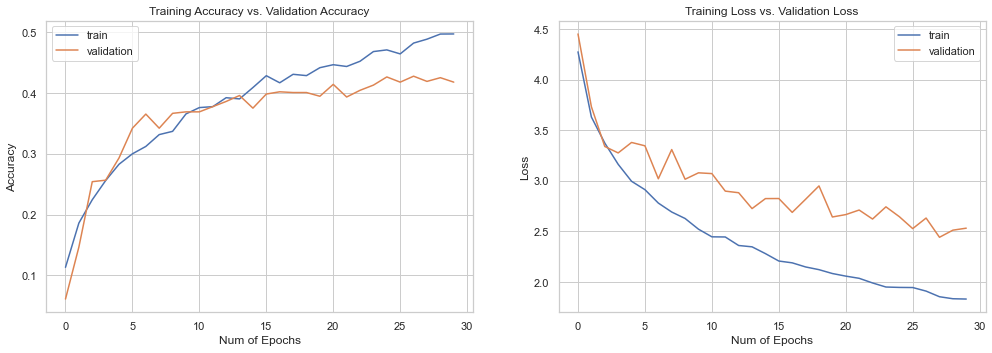

In [ ]:
plot_model_history('model_ResNet50', model_ResNet50_info, epochsResNet)

### SqueezeNet Inspired

model_SqueezeNetInspired


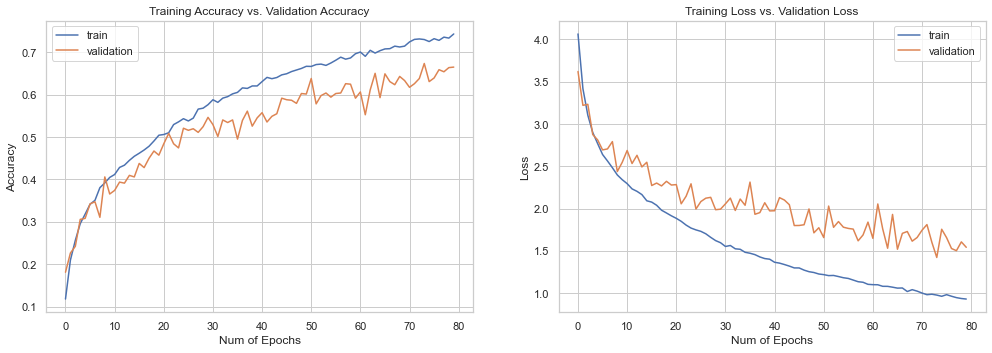

In [ ]:
plot_model_history('model_SqueezeNetInspired', model_SqueezeNetInspired_info, epochsSqueezeNet)

### VGG19

model_VGG19


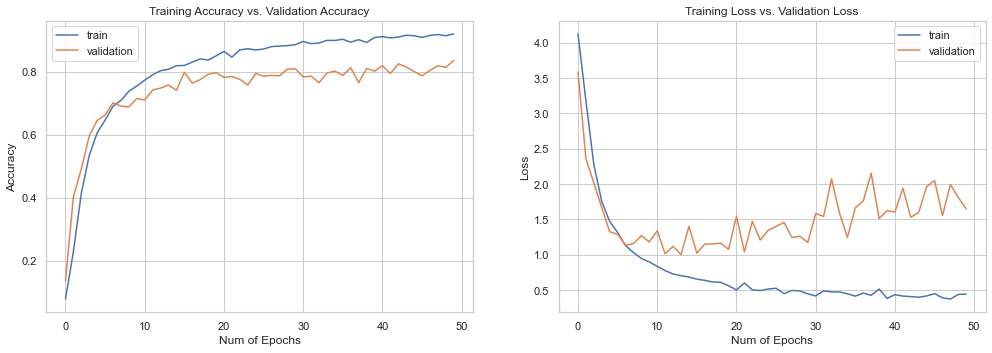

In [ ]:
plot_model_history('model_VGG19', model_VGG19_info, epochsVGG19)

## Model Output Examples

In [ ]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

### ResNet50

In [ ]:
# getting predictions on val set.
resnet_pred=model_ResNet50.predict(X_valid)
resnet_pred_digits=np.argmax(resnet_pred,axis=1)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_valid)):
    if(np.argmax(y_valid[i])==resnet_pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_valid)):
    if(not np.argmax(y_valid[i])==resnet_pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

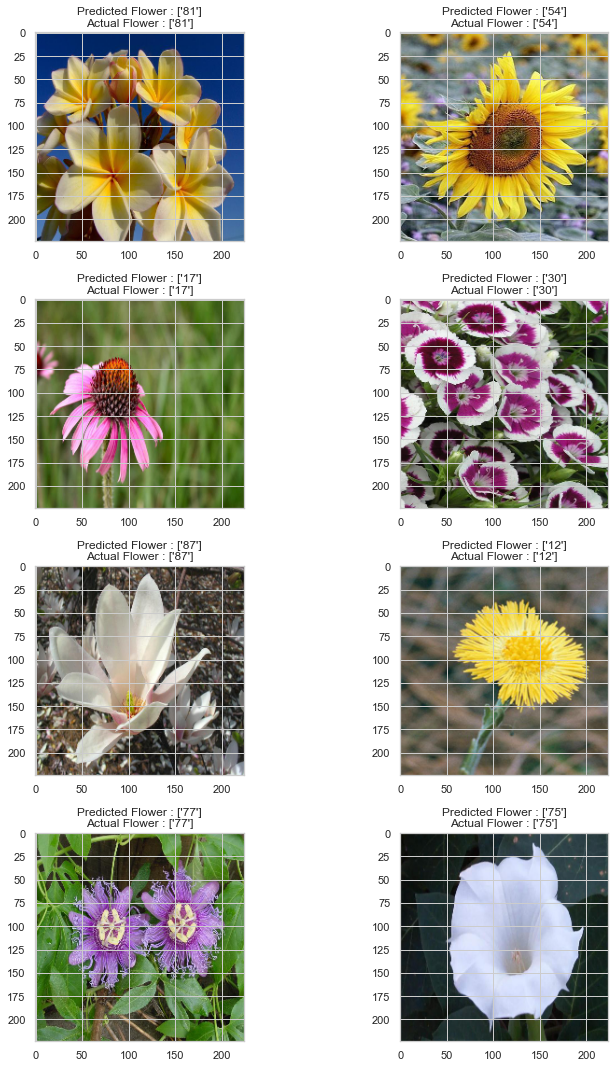

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(X_valid[prop_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([resnet_pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_valid[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

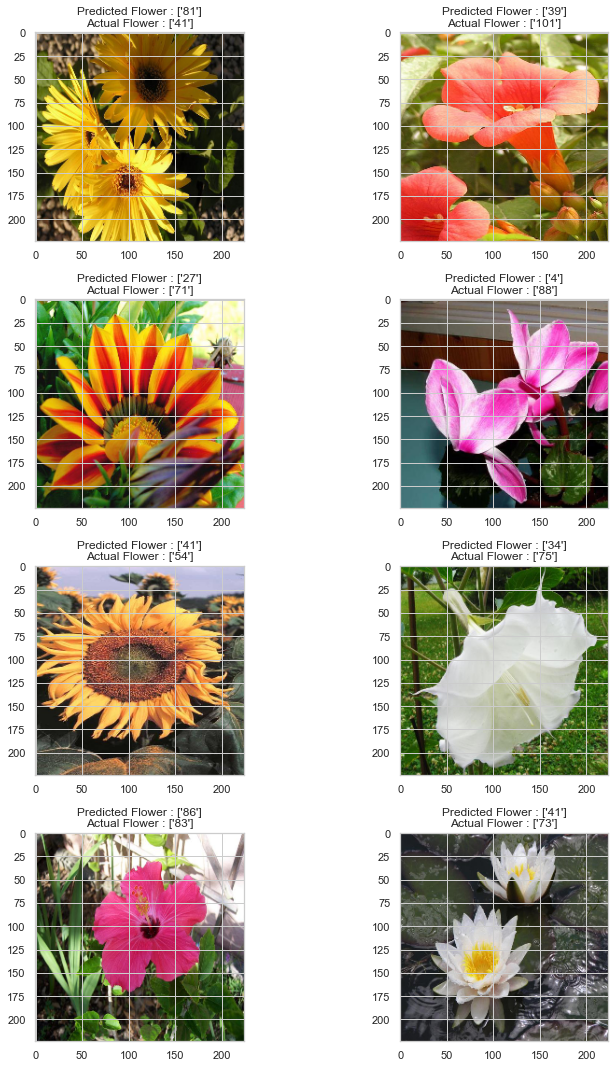

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(X_valid[mis_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([resnet_pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_valid[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

### SqueezeNet Inspired Model

In [ ]:
# getting predictions on val set.
squeezenet_pred=model_SqueezeNetInspired.predict(X_valid)
squeezenet_pred_digits=np.argmax(squeezenet_pred,axis=1)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_valid)):
    if(np.argmax(y_valid[i])==squeezenet_pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_valid)):
    if(not np.argmax(y_valid[i])==squeezenet_pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

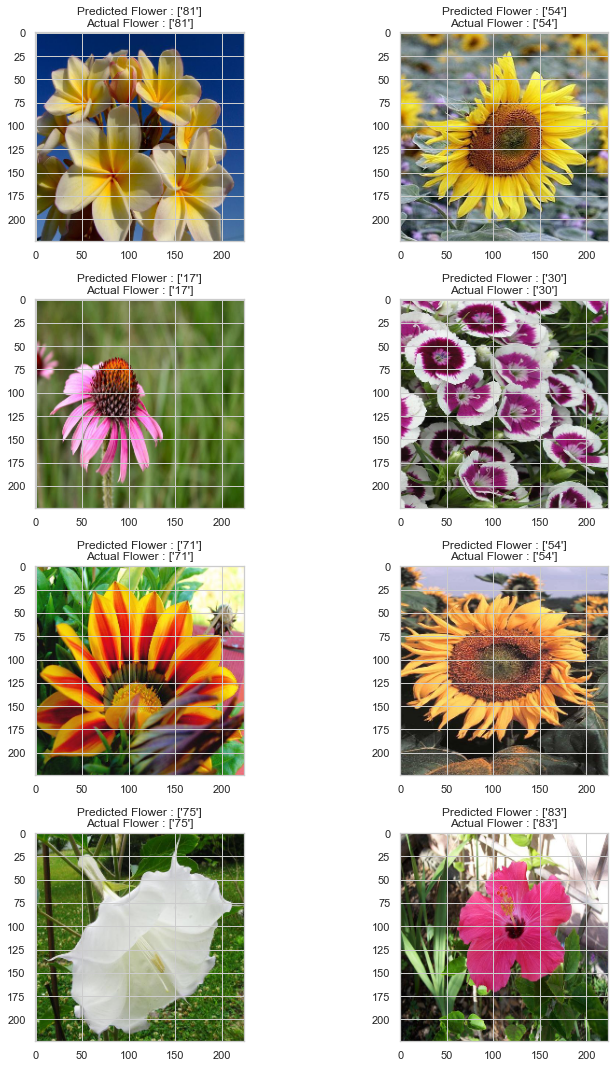

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(X_valid[prop_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([squeezenet_pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_valid[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

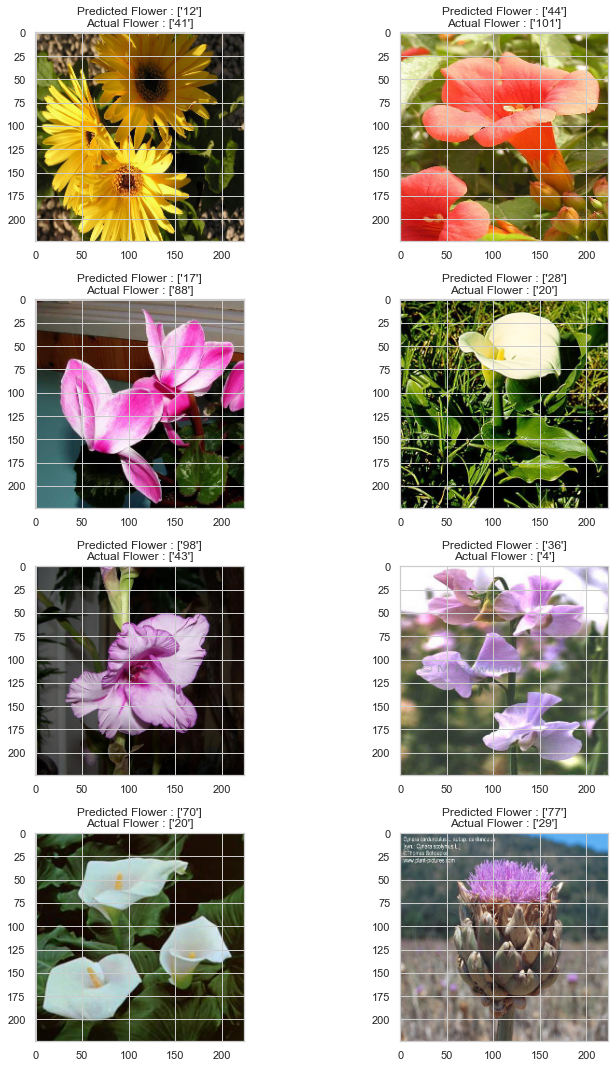

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(X_valid[mis_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([squeezenet_pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_valid[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

### VGG19

In [ ]:
# getting predictions on val set.
vgg19_pred=model_VGG19.predict(X_valid)
vgg19_pred_digits=np.argmax(vgg19_pred,axis=1)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_valid)):
    if(np.argmax(y_valid[i])==vgg19_pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_valid)):
    if(not np.argmax(y_valid[i])==vgg19_pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

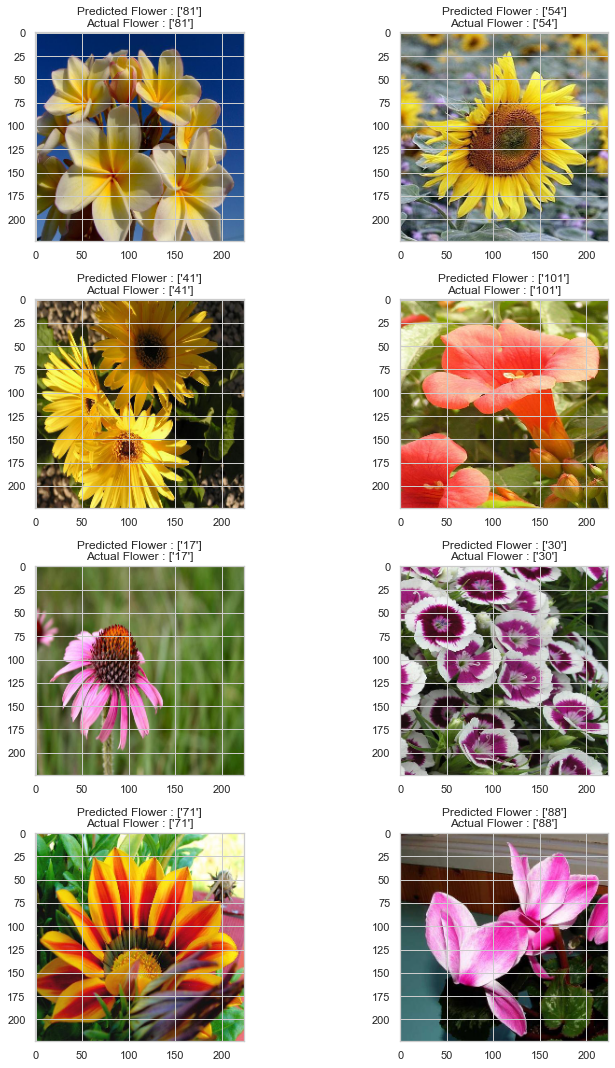

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(X_valid[prop_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([vgg19_pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_valid[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

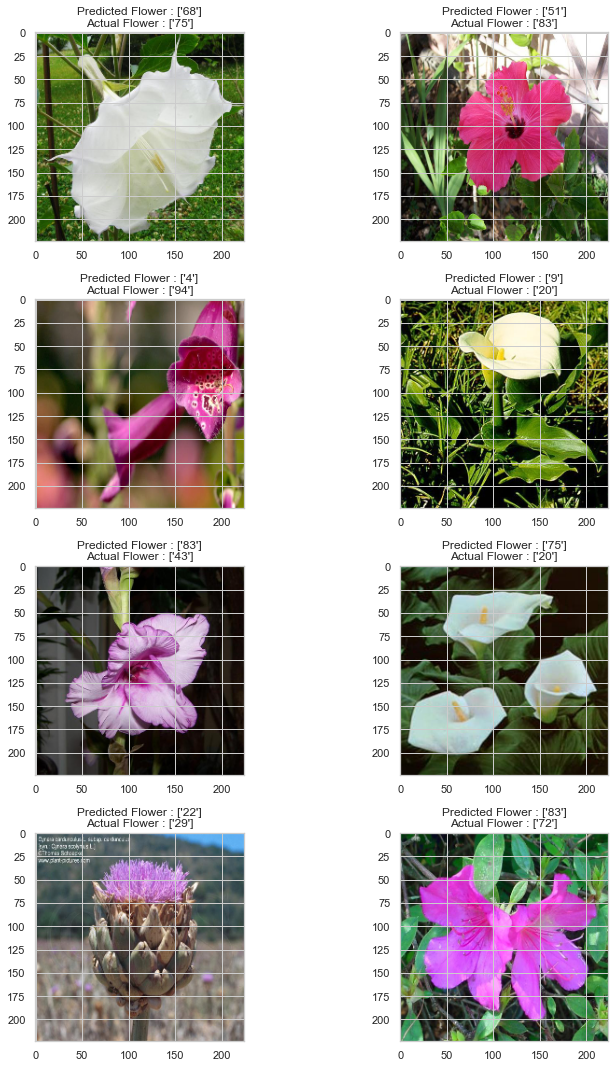

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(X_valid[mis_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([vgg19_pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_valid[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

## Model Classification Report

In [ ]:
def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title = 'Confusion matrix',
                              cmap = plt.cm.ocean):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)

    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

def disp_confusion_matrix(y, y_pred, model_name):

    cm = confusion_matrix(y, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes= le.inverse_transform([0, 1, 2, 3, 4, 5]), normalize=False, 
                                 title = model_name + '\nConfusion Matrix')
    plt.show()

### ResNet50

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.17      0.62      0.26         8
           1       0.75      0.75      0.75         4
           2       0.80      0.67      0.73         6
           3       0.00      0.00      0.00         5
           4       1.00      0.67      0.80         6
           5       0.08      0.10      0.09        10
           6       0.50      0.40      0.44         5
           7       0.12      0.20      0.15         5
           8       0.12      1.00      0.22         1
           9       0.83      0.71      0.77         7
          10       0.00      0.00      0.00         2
          11       0.72      0.81      0.76        16
          12       0.44      0.36      0.40        11
          13       0.14      0.25      0.18         4
          14       0.60      1.00      0.75         6
          15       1.00      0.43      0.60         7
          16       1.00      0.25      0.40         4
          17       0.25    

### SqueezeNet Inspired Model

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       1.00      0.25      0.40         4
           2       0.86      1.00      0.92         6
           3       1.00      0.20      0.33         5
           4       0.80      0.67      0.73         6
           5       0.40      0.20      0.27        10
           6       0.50      1.00      0.67         5
           7       0.33      0.80      0.47         5
           8       0.17      1.00      0.29         1
           9       0.67      0.29      0.40         7
          10       0.33      0.50      0.40         2
          11       0.67      1.00      0.80        16
          12       0.71      0.45      0.56        11
          13       0.33      0.75      0.46         4
          14       0.56      0.83      0.67         6
          15       1.00      0.14      0.25         7
          16       1.00      0.75      0.86         4
          17       0.83    

### VGG19

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         6
           5       0.83      0.50      0.62        10
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         7
          10       0.17      0.50      0.25         2
          11       0.94      1.00      0.97        16
          12       1.00      0.91      0.95        11
          13       0.33      0.50      0.40         4
          14       1.00      1.00      1.00         6
          15       1.00      0.57      0.73         7
          16       0.80      1.00      0.89         4
          17       0.88    